In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from collections import Counter 
from tqdm import tqdm
from random import seed, randint, choice

from swarm_sim import *

%matplotlib inline 

In [2]:
PATH = '..\data\Traces_Nanosatellites\\track_'
satellites = {}

with tqdm(total=100, desc='Extracting data') as pbar:
    for i in range(0,100):
        df = pd.read_csv(PATH+str(i)+'.csv', sep=',', header=0)
        df['coords'] = ['x','y','z']
        satellites[i] = df.set_index('coords', drop=True)
        pbar.update(1)
    
DURATION = satellites[0].columns.tolist()

satellites[0].head()

Extracting data: 100%|██████████| 100/100 [02:07<00:00,  1.27s/it]


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
coords,,,,,,,,,,,,,,,,,,,,,
x,-4.850747e+05,-4.937755e+05,-5.024536e+05,-5.111086e+05,-5.197401e+05,-5.283476e+05,-5.369309e+05,-5.454894e+05,-5.540229e+05,-5.625310e+05,...,1.490967e+06,1.494274e+06,1.497573e+06,1.500865e+06,1.504149e+06,1.507425e+06,1.510693e+06,1.513954e+06,1.517206e+06,1.520451e+06
y,-7.066530e+05,-7.201117e+05,-7.335372e+05,-7.469290e+05,-7.602864e+05,-7.736088e+05,-7.868957e+05,-8.001464e+05,-8.133603e+05,-8.265368e+05,...,2.218138e+06,2.223313e+06,2.228477e+06,2.233629e+06,2.238769e+06,2.243898e+06,2.249015e+06,2.254120e+06,2.259214e+06,2.264296e+06
z,-2.026363e+06,-2.019625e+06,-2.012795e+06,-2.005871e+06,-1.998855e+06,-1.991747e+06,-1.984548e+06,-1.977257e+06,-1.969876e+06,-1.962403e+06,...,3.692429e+06,3.686602e+06,3.680756e+06,3.674890e+06,3.669006e+06,3.663103e+06,3.657180e+06,3.651239e+06,3.645278e+06,3.639299e+06


In [3]:
CONNECTION_RANGE = 30000
CHUNKS = 1800     # Number of timestamps to analyse
NB_NODES = 100

swarm_topo = {}

with tqdm(total=CHUNKS, desc='Converting to Swarm') as pbar:
    for t in range(CHUNKS):
        swarm_topo[t] = Swarm(
            connection_range=CONNECTION_RANGE, 
            nodes=[Node(id, node[str(t)].x, node[str(t)].y, node[str(t)].z) for id,node in satellites.items()]
        )
        pbar.update(1)

print(swarm_topo[0])

with tqdm(total=len(swarm_topo.keys()), desc='Neighbor matrix') as pbar:
    for t in swarm_topo.keys():
        neighbor_matrix = swarm_topo[t].neighbor_matrix()
        pbar.update(1)

Converting to Swarm: 100%|██████████| 1800/1800 [00:16<00:00, 109.56it/s]


Swarm of 100 node(s), connection range: 30000


Neighbor matrix: 100%|██████████| 1800/1800 [00:18<00:00, 98.49it/s] 


In [4]:
# Reference temporal evolution: Average Degree, Average Clustering Coefficient
ref_ad, ref_acc = [], []

for t,swarm in swarm_topo.items():
    ref_ad.append(np.mean(swarm.degree()))
    ref_acc.append(np.mean(swarm.cluster_coef()))
    
# Run only once
"""
diameters = []
with tqdm(total=len(swarm_topo.keys()), desc='Diameter') as pbar:
    for swarm in swarm_topo.values():
        diameters.append(swarm.diameter(swarm)[2]-1)
        pbar.update(1)
ref_dia = np.mean(diameters)
"""

"\ndiameters = []\nwith tqdm(total=len(swarm_topo.keys()), desc='Diameter') as pbar:\n    for swarm in swarm_topo.values():\n        diameters.append(swarm.diameter(swarm)[2]-1)\n        pbar.update(1)\nref_dia = np.mean(diameters)\n"

In [5]:
print('Maximum AD:', np.max(ref_ad), '\tTimestamp:', ref_ad.index(np.max(ref_ad)))
print('Maximum ACC:', np.max(ref_acc), '\tTimestamp:', ref_acc.index(np.max(ref_acc)))

print('\nMinimum AD:', np.min(ref_ad), '\tTimestamp:', ref_ad.index(np.min(ref_ad)))
print('Minimum ACC:', np.min(ref_acc), '\tTimestamp:', ref_acc.index(np.min(ref_acc)))


Maximum AD: 10.88 	Timestamp: 1505
Maximum ACC: 0.5879346991681088 	Timestamp: 219

Minimum AD: 5.3 	Timestamp: 816
Minimum ACC: 0.39613720593132357 	Timestamp: 1043


In [14]:
def colormap(swarm, val, title=None, vmin=0, vmax=25):
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection='3d')
    x_data = [node.x for node in swarm.nodes]
    y_data = [node.y for node in swarm.nodes]
    z_data = [node.z for node in swarm.nodes]
    
    cm = plt.cm.get_cmap('RdYlBu_r')
    sc = ax.scatter(x_data, y_data, z_data, c=val, s=35, edgecolors='black', cmap=cm, vmin=vmin, vmax=vmax)
    plt.colorbar(sc)
    ax.set_title(title)

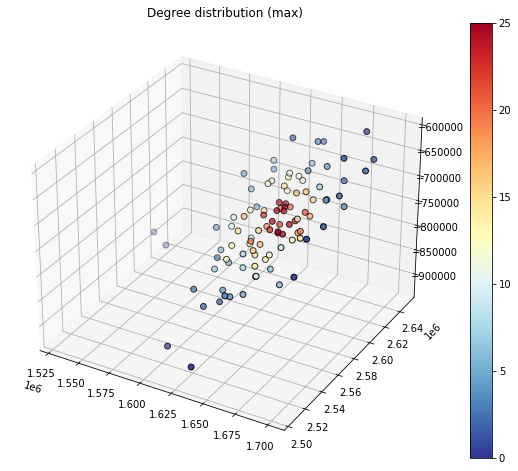

In [15]:
swarm = swarm_topo[1505]
colormap(swarm, val=swarm.degree(), title='Degree distribution (max)')

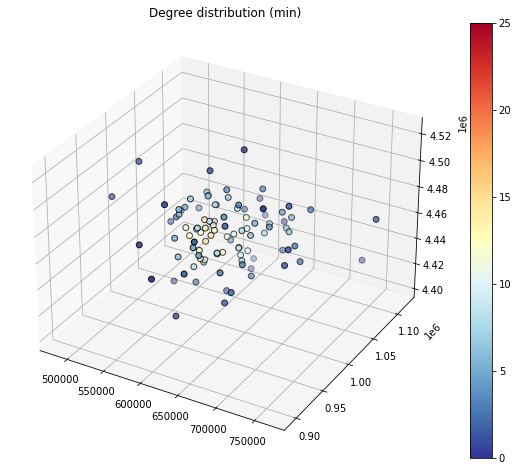

In [16]:
swarm = swarm_topo[816]
colormap(swarm, val=swarm.degree(), title='Degree distribution (min)')

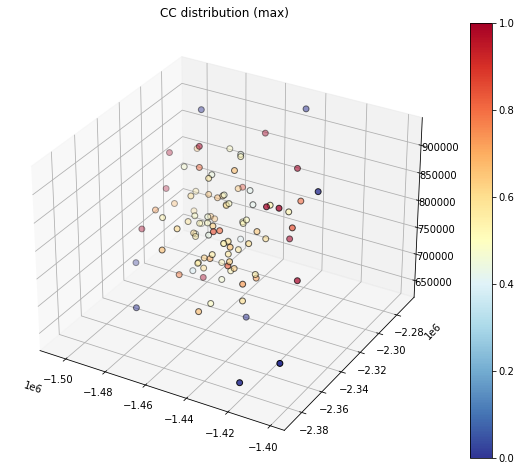

In [17]:
swarm = swarm_topo[219]
colormap(swarm, val=swarm.cluster_coef(), title='CC distribution (max)', vmax=1)

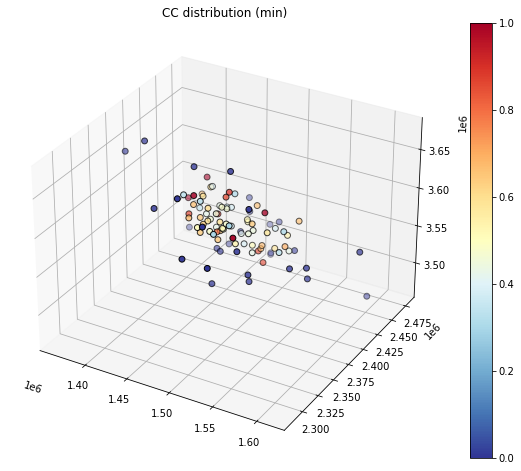

In [18]:
swarm = swarm_topo[1043]
colormap(swarm, val=swarm.cluster_coef(), title='CC distribution (min)', vmax=1)

In [34]:
def top_n_sources(swarm, n=10):
    p = {} #proba of each node to become a source
    degrees = swarm.degree()
    for node in swarm.nodes:
        ndeg = degrees[node.id]
        p[node.id] = 0.
        if ndeg > 0:
            p[node.id] = 1./ndeg
    return dict(sorted(p.items(), key=lambda x:x[1], reverse=True)[:n])

def param_MDRW(swarm, src_ids, s=1, overlap=False):
    sources = [swarm.get_node_by_id(id) for id in src_ids]
    swarms = {} # Dict(group ID:Swarm)
    for i,src in enumerate(sources): # Initialize swarms
        src.set_group(i)
        swarms[i] = Swarm(swarm.connection_range, nodes=[src])
    free_nodes = [n for n in swarm.nodes if n.group==-1]
    while free_nodes: # Spread paths to desired length
        for k in swarms.keys():
            n_i = swarms[k].nodes[-1] # Current node
            free_neighbors = set(free_nodes).intersection(n_i.neighbors)
            if free_neighbors: # At least one unassigned neighbor
                n_j = n_i.random_walk(s, overlap) # Next node
            else:
                n_j = swarm.random_jump(s, overlap) # If no neighbor, perform random jump in the graph
            n_j.set_group(n_i.group)
            swarms[k].add_node(n_j) 
            free_nodes.remove(n_j)
    return swarms
    

In [22]:
def plot_groups(swarms, title=None, show_edges=True):
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    colordict = {
        0:'tab:blue',
        1:'tab:orange',
        2:'tab:green',
        3:'tab:red',
        4:'tab:purple',
        5:'tab:brown',
        6:'tab:pink',
        7:'tab:gray',
        8:'tab:olive',
        9:'tab:cyan',
        -1:'w'
    }
    
    for gid, swarm in swarms.items():
        x_data = [node.x for node in swarm.nodes]
        y_data = [node.y for node in swarm.nodes]
        z_data = [node.z for node in swarm.nodes]
        sc = ax.scatter(x_data, y_data, z_data, 
                        c=colordict[gid], 
                        s=45, 
                        edgecolors='black',
                        label=str(gid))
        if show_edges:
            for node in swarm.nodes:
                for n in node.neighbors:
                    if n.group==gid:
                        ax.plot([node.x, n.x], [node.y, n.y], [node.z, n.z], 
                                c=colordict[gid]
                                )
    
    ax.legend(title='Groups')
    
    ax.set_title(title)

In [54]:
def diameter(swarm, group, default=-1):
    G = swarm.swarm_to_nxgraph()
    node_ids = [n.id for n in group.nodes]
    max_length = (0,0,0) # Source, target, number of hops
    for ni in node_ids:
        for nj in node_ids:
            nb_hops = default
            if nx.has_path(G, ni, nj):
                nb_hops = len(nx.shortest_path(G, ni, nj)) -1
            if nb_hops > max_length[2]:
                max_length = (ni, nj, nb_hops)
    return max_length

## Param-MDRW division
Repeat 100 times on best (1505) and worst (816) case scenarii

In [46]:
swarm_case = {1505:swarm_topo[1505], 816:swarm_topo[816]}
nb_seeds = 100

In [47]:
param_mdrw_swarms = {}
for t,swarm in swarm_case.items():
    groups = []
    top10 = top_n_sources(swarm, n=10)
    src_ids = list(top10.keys())
    for s in range(nb_seeds):
        swarm.reset_groups()
        swarm_dict = param_MDRW(swarm, src_ids, s)
        groups.extend(list(swarm_dict.values()))
    param_mdrw_swarms[t] = groups


In [48]:
len(param_mdrw_swarms[1505])

1000

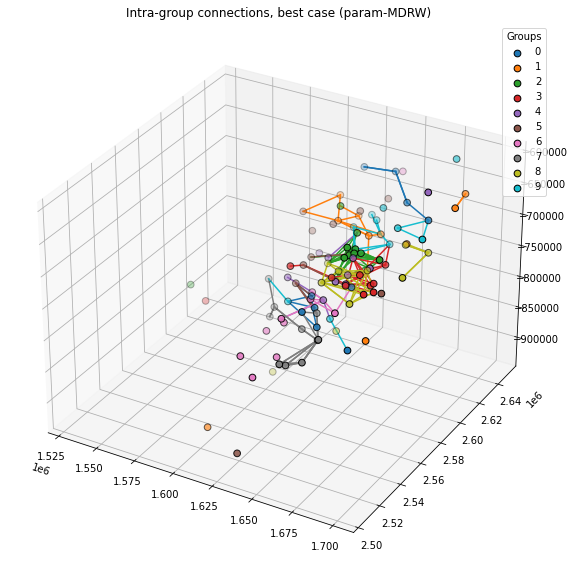

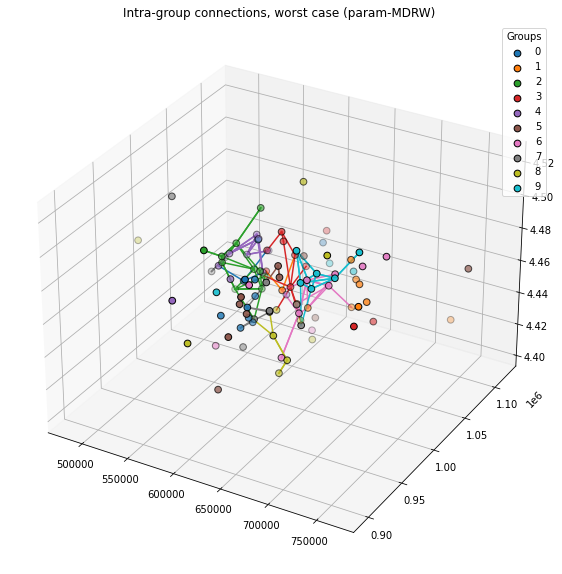

In [38]:
best, worst = {}, {}
for i in range(10):
    best[i] = param_mdrw_swarms[1505][i]
    worst[i] = param_mdrw_swarms[816][i]
    
plot_groups(best, title='Intra-group connections, best case (param-MDRW)')
plot_groups(worst, title='Intra-group connections, worst case (param-MDRW)')

In [58]:
ref_dias = {}
for t, swarm in swarm_case.items():
    ref_dias[t] = diameter(swarm, swarm, default=0)[2]
    
print('Best case reference:', ref_dias[1505], '\tConnected components:', len(swarm_case[1505].connected_components()))
print('Worst case reference:', ref_dias[816], '\tConnected components:', len(swarm_case[816].connected_components()))

Best case reference: 12 	Connected components: 8
Worst case reference: 11 	Connected components: 17


In [57]:
best_dia = []
best_cc = []
swarms = param_mdrw_swarms[1505]
with tqdm(total=len(swarms), desc='Best case') as pbar:
    for sw in swarms:
        best_dia.append(diameter(swarm_topo[1505], sw, default=0)[2])
        best_cc.append(len(sw.connected_components()))
        pbar.update(1)
print('Average Dia:', np.mean(best_dia), '\tDeviation:', np.std(best_dia))
print('Average number of connected components:', np.mean(best_cc), '\n')

worst_dia = []
worst_cc = []
swarms = param_mdrw_swarms[816]
with tqdm(total=len(swarms), desc='Worst case') as pbar:
    for sw in swarms:
        worst_dia.append(diameter(swarm_topo[816], sw, default=0)[2])
        worst_cc.append(len(sw.connected_components()))
        pbar.update(1)
print('Average Dia:', np.mean(worst_dia), '\tDeviation:', np.std(worst_dia))
print('Average number of connected components:', np.mean(worst_cc))


Best case: 100%|██████████| 1000/1000 [00:10<00:00, 99.01it/s]


Average Dia: 6.414 	Deviation: 2.6070297274868195
Average number of connected components: 2.844 



Worst case: 100%|██████████| 1000/1000 [00:09<00:00, 108.27it/s]

Average Dia: 5.901 	Deviation: 2.0241538973111703
Average number of connected components: 3.8


## Classic MDRW division
Repeat 100 times on best (1505) and worst (816) case scenarii

In [59]:
mdrw_swarms = {}
for t,swarm in swarm_case.items():
    groups = []
    for s in range(nb_seeds):
        swarm.reset_groups()
        swarm_dict = swarm.MDRW(10, s)
        groups.extend(list(swarm_dict.values()))
    mdrw_swarms[t] = groups
    
len(mdrw_swarms[1505])

1000

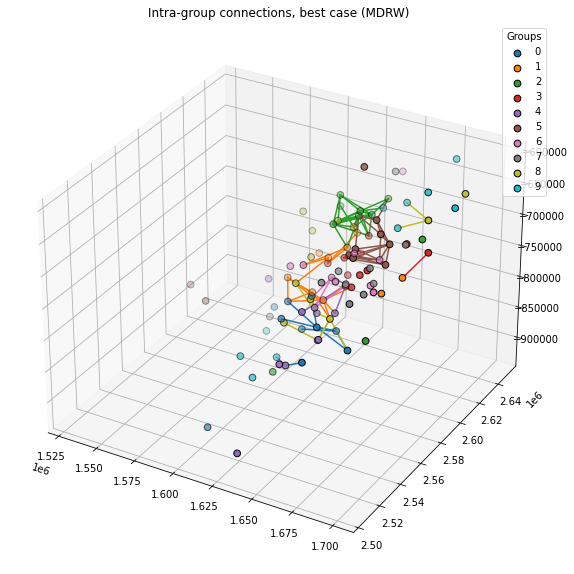

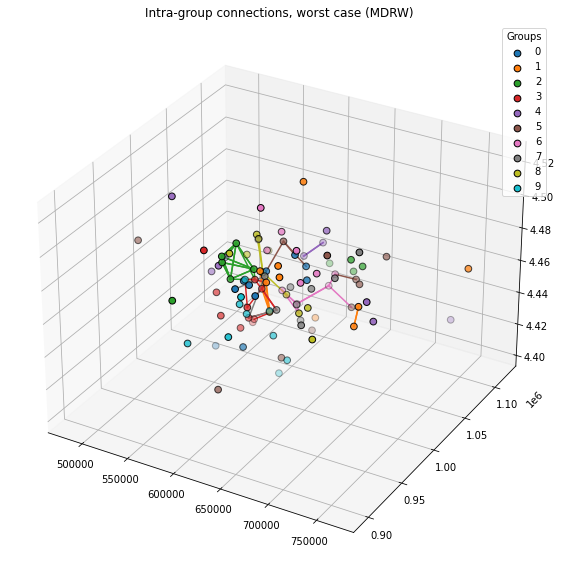

In [43]:
best, worst = {}, {}
for i in range(10):
    best[i] = mdrw_swarms[1505][i]
    worst[i] = mdrw_swarms[816][i]
    
plot_groups(best, title='Intra-group connections, best case (MDRW)')
plot_groups(worst, title='Intra-group connections, worst case (MDRW)')

In [60]:
best_dia = []
best_cc = []
swarms = mdrw_swarms[1505]
with tqdm(total=len(swarms), desc='Best case') as pbar:
    for sw in swarms:
        best_dia.append(diameter(swarm_topo[1505], sw, default=0)[2])
        best_cc.append(len(sw.connected_components()))
        pbar.update(1)
print('Average Dia:', np.mean(best_dia), '\tDeviation:', np.std(best_dia))
print('Average number of connected components:', np.mean(best_cc), '\n')

worst_dia = []
worst_cc = []
swarms = mdrw_swarms[816]
with tqdm(total=len(swarms), desc='Worst case') as pbar:
    for sw in swarms:
        worst_dia.append(diameter(swarm_topo[816], sw, default=0)[2])
        worst_cc.append(len(sw.connected_components()))
        pbar.update(1)
print('Average Dia:', np.mean(worst_dia), '\tDeviation:', np.std(worst_dia))
print('Average number of connected components:', np.mean(worst_cc))

Best case: 100%|██████████| 1000/1000 [00:10<00:00, 95.90it/s]


Average Dia: 6.103 	Deviation: 2.5962262998436794
Average number of connected components: 2.828 



Worst case: 100%|██████████| 1000/1000 [00:08<00:00, 112.92it/s]

Average Dia: 6.193 	Deviation: 1.993426948749314
Average number of connected components: 3.981
